In [236]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



# Identificar una serie de tiempo ARMA

Generamos artificialmente la serie

Ejemplo basado en el libro Peixeiro, M. (2022). Time series forecasting in python. Simon and Schuster.

In [237]:
df = pd.read_csv('../datasets/bandwidth.csv')

<Axes: title={'center': 'Ancho de banda de la red'}>

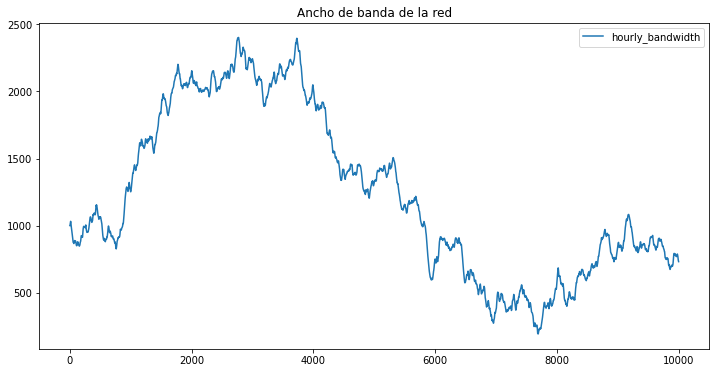

In [238]:
df.plot(figsize=(12, 6), title='Ancho de banda de la red')

In [239]:
ADF_result = adfuller(df['hourly_bandwidth'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199451994
p-value: 0.7972240255014788


El p-valor nos indica que no es una serie estacionaria...hay que calcular el diferencia...

In [240]:
ldf  = df.copy() 
ldf["values_diff"] = df['hourly_bandwidth'].diff()
ldf.dropna(inplace=True)

Ploteamos ambos, original y diferencia orden 1

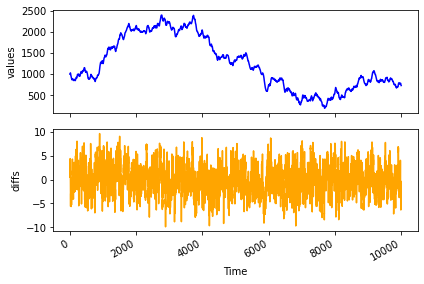

In [241]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(ldf['hourly_bandwidth'], color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(ldf['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Si, ahora si es estacionaria...

In [242]:
ADF_result = adfuller(ldf['values_diff'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789028
p-value: 0.0


Mostramos un acf plot, queda claro que no es un random walk. También observamos que la caída no es abrupta, por tanto no estamos en un caso de moving average puro.

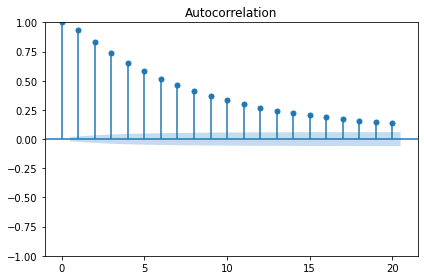

In [243]:
plot_acf(ldf['values_diff'], lags=20)
plt.tight_layout()
plt.show()

Ploteamos un pacf plot, queda claro que hay un componente autoregresivo pero este podría no ser puro, se nota un comportamiento sinusoidal y la caída no es abrupta (El ejemplo es teóricamente real. El autor en el libro expone el fenómeno de manera mas clara usando datos sintéticos).

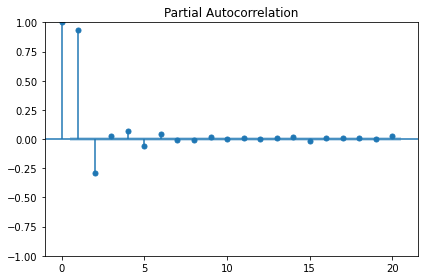

In [244]:
plot_pacf(ldf['values_diff'], lags=20)
plt.tight_layout()
plt.show()


Por lo tanto, debe ser una combinación de procesos autorregresivos y de media móvil, lo que resulta en un proceso de media móvil autorregresiva que se puede modelar con el modelo ARMA(p,q), donde p es el orden del proceso autorregresivo y q es el orden de la media móvil.

Es difícil usar los gráficos ACF y PACF para encontrar respectivamente p y q, así que ajustaremos muchos modelos ARMA(p,q) con diferentes combinaciones de valores para p y q. Luego seleccionaremos un modelo de acuerdo con el criterio de Akaike y evaluar su viabilidad analizando sus residuos. Idealmente, los residuos de un modelo tendrán características similares al ruido blanco. Luego podremos utilizar este modelo para hacer pronósticos. Para este ejemplo, pronosticaremos el uso de ancho de banda horario durante las próximas dos horas.

In [245]:
from itertools import product
ps = range(0, 4, 1)    
qs = range(0, 4, 1)
#Producto cartesiano de los valores de p y q
# Esto genera todas las combinaciones posibles de p y q
order_list = list(product(ps, qs))

Antes de continuar ajusto el indice con fechas...evito warnings

In [246]:
ldf.index = pd.date_range(start='2020-01-01', periods=len(ldf), freq='H')

Como siempre, dividimos en entrenamiento y test

In [247]:
#train_size = int(len(ldf) * 0.9)
#test_size = len(ldf) - train_size
#A veces hacerlo por porcentaje trae problemas con el window...¿Tiene que ser divisible por el window?

test_size = 168
train_size = len(ldf) - test_size

In [248]:
test = ldf.iloc[train_size:][['values_diff']]
train  = ldf.iloc[:train_size-1][['values_diff']]

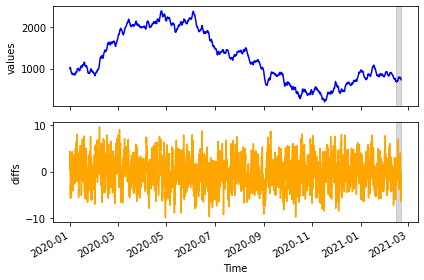

In [249]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

start_date  = test.index.min()
end_date    = test.index.max()
ax1.plot(ldf['hourly_bandwidth'], color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
ax1.axvspan(start_date, end_date, color='#444444', alpha=0.2)

ax2.plot(ldf['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
ax2.axvspan(start_date, end_date, color="#444444", alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()


Calculamos resultados para todas las combinaciones (Demora)

In [250]:
results = []
for p, q in order_list:
    try:
        model = SARIMAX(train['values_diff'], order=(p, 0, q), simple_differencing=False)
        model_fit = model.fit(disp=False)
    except:
        print(f"Error with order ({p}, {q}), skipping...")
        continue
    aic = model_fit.aic
    results.append([(p, q), aic])


c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Ordenamos los resultados y verificamos el ganador.

In [251]:
result_df = pd.DataFrame(results)
result_df.columns = ['(p,q)', 'AIC']
#Sort in ascending order, lower AIC is better
result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
result_df.loc[:5,:]

,"(p,q)",AIC
0,"(3, 2)",27988.503772
1,"(2, 3)",27988.729803
2,"(2, 2)",27989.033292
3,"(3, 3)",27990.821443
4,"(1, 3)",28000.826945
5,"(1, 2)",28048.710076


El AIC es una medida relativa de la calidad. Necesitamos una medida absoluta de la calidad general del modelo, para eso debemos analizar los residuos. Ultimo paso antes de proceder a hacer las predicciones. Debemos responder las siguientes preguntas: 1.¿El Q-Q plot muestra una linea mas o menos recta (responde a una distribución normal)? 2.¿Los residuos son no correlacionados? Si estas respuestas son afirmativas entonces nos quedamos con (2,2) caso contrario analizamos otra combinación prometedora.

Necesitamos que residuos se comporten como ruido blanco (es decir, independientes y normalmente distribuidos con media cero), para que el modelo sea adecuado.

El ganador es 3,2, lo aplicamos.

In [252]:
p, q = result_df.loc[0].values[0]

In [253]:
model = SARIMAX(train['values_diff'], order=(p,0,q), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            values_diff   No. Observations:                 9830
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -13988.252
Date:                Wed, 23 Jul 2025   AIC                          27988.504
Time:                        16:39:24   BIC                          28031.663
Sample:                    01-01-2020   HQIC                         28003.125
                         - 02-13-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3531      0.053      6.663      0.000       0.249       0.457
ar.L2          0.4150      0.066      6.249      0.000       0.285       0.545
ar.L3          0.0545      0.036      1.528      0.1

Diagnósticos generales

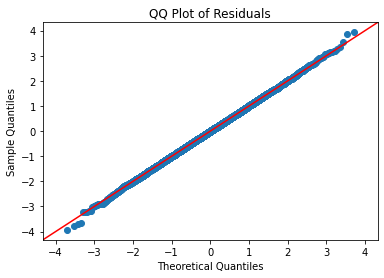

In [254]:
from statsmodels.graphics.gofplots import qqplot
residuals = model_fit.resid
qqplot(residuals, line='45');
plt.title('QQ Plot of Residuals')
plt.show()

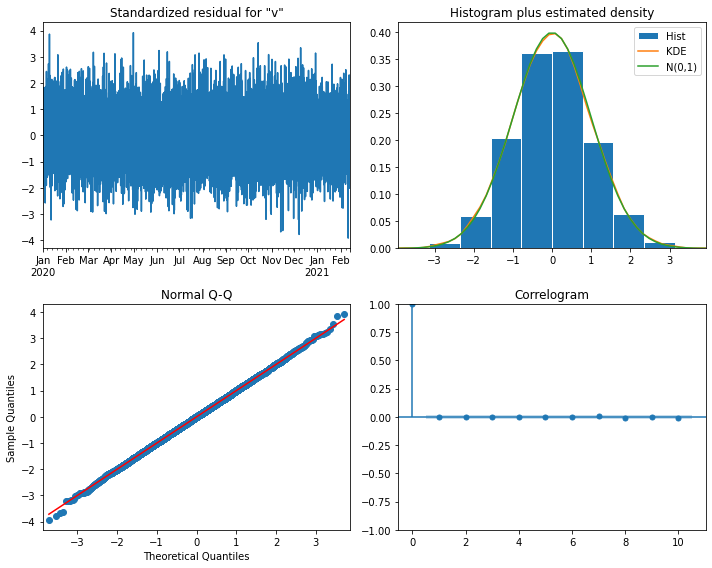

In [255]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

Revisamos los residuos

Test de Ljung-Box

In [256]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(ljung)

     lb_stat  lb_pvalue
1   0.000767   0.977908
2   0.015820   0.992121
3   0.047269   0.997305
4   0.082838   0.999166
5   0.322699   0.997194
6   0.375501   0.999041
7   0.466318   0.999561
8   1.370955   0.994649
9   1.392350   0.997869
10  1.883608   0.997157


In [257]:
def rolling_forecast(df=None, train_len=100, horizon=2, window=2, method='mean', p=None, q=None) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i])
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(p,0,q))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

Hacemos la predicción, se demora 30 minutos

In [258]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
print(f'TRAIN_LEN: {TRAIN_LEN}, HORIZON: {HORIZON}, WINDOW: {WINDOW}')

TRAIN_LEN: 9830, HORIZON: 168, WINDOW: 2


In [259]:
pred_mean       = rolling_forecast(ldf['values_diff'], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(ldf['values_diff'], TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA       = rolling_forecast(ldf['values_diff'], TRAIN_LEN, HORIZON, WINDOW, 'ARMA',3, 2)


In [260]:
test.loc[:, 'pred_mean']        = pred_mean
test.loc[:, 'pred_last_value']  = pred_last_value
test.loc[:, 'pred_ARMA']        = pred_ARMA

test.head()

,values_diff,pred_mean,pred_last_value,pred_ARMA
2021-02-13 15:00:00,-5.943995,-0.027628,-5.077391,-4.942518
2021-02-13 16:00:00,-5.865194,-0.027628,-5.077391,-4.423710
2021-02-13 17:00:00,-3.197066,-0.028816,-5.943995,-5.477567
2021-02-13 18:00:00,-1.090197,-0.028816,-5.943995,-4.877227
2021-02-13 19:00:00,0.665291,-0.029732,-3.197066,-2.164184


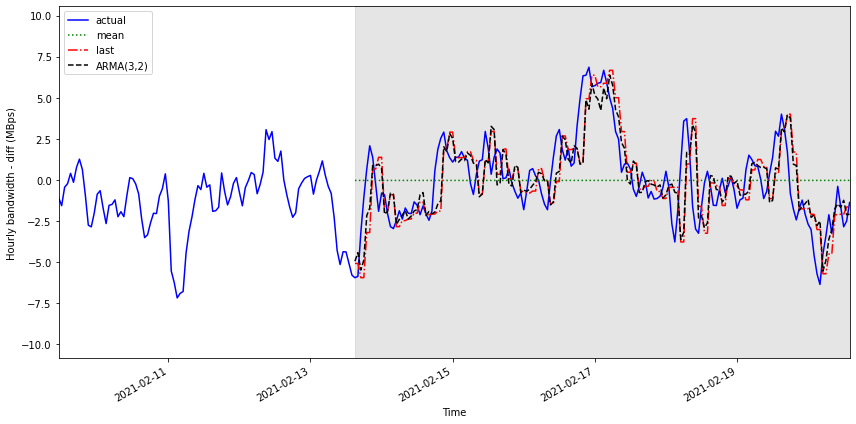

In [261]:
start_date  = ldf.index[ldf.index.get_loc(test.index.min())-100]
end_date    = test.index.max()

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ldf['values_diff'], color='blue', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(3,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(test.index.min(), test.index.max(), color='#808080', alpha=0.2)

ax.set_xlim(start_date, end_date)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()


El mejor resultado es utilizando ARMA

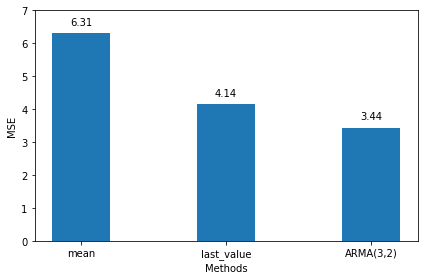

In [262]:
mse_mean = mean_squared_error(test['values_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['values_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['values_diff'], test['pred_ARMA'])

fig, ax = plt.subplots()

x = ['mean', 'last_value', f'ARMA({p},{q})']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()
plt.show()